In [1]:
pip install keras-cv --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 21.2 MB/s 


In [2]:
pip install luketils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers

import keras_cv
from keras_cv import bounding_box
import os
from luketils import visualization

BATCH_SIZE = 16
EPOCHS = int(os.getenv("EPOCHS", "20"))
CHECKPOINT_PATH = os.getenv("CHECKPOINT_PATH", "checkpoint/")
INFERENCE_CHECKPOINT_PATH = os.getenv("INFERENCE_CHECKPOINT_PATH", CHECKPOINT_PATH)

In [4]:
train_ds, ds_info = keras_cv.datasets.pascal_voc.load(
    split='train', bounding_box_format='xywh', batch_size=8
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete85152T/voc-test.tfrecord*...:   0%|          | 0/4952…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete85152T/voc-train.tfrecord*...:   0%|          | 0/250…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/voc/2007/4.0.0.incomplete85152T/voc-validation.tfrecord*...:   0%|          | …

Dataset voc downloaded and prepared to ~/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


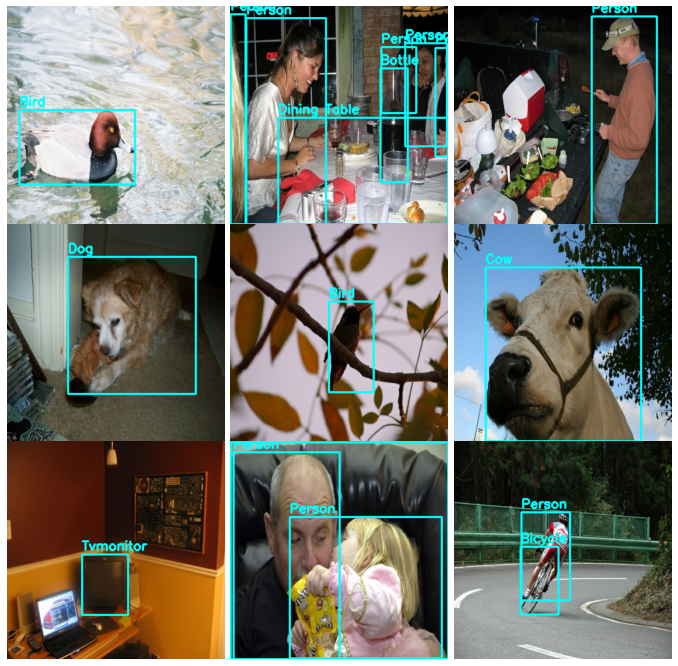

In [5]:
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train", bounding_box_format="xywh", batch_size=BATCH_SIZE
)

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )


visualize_dataset(dataset, bounding_box_format="xywh")


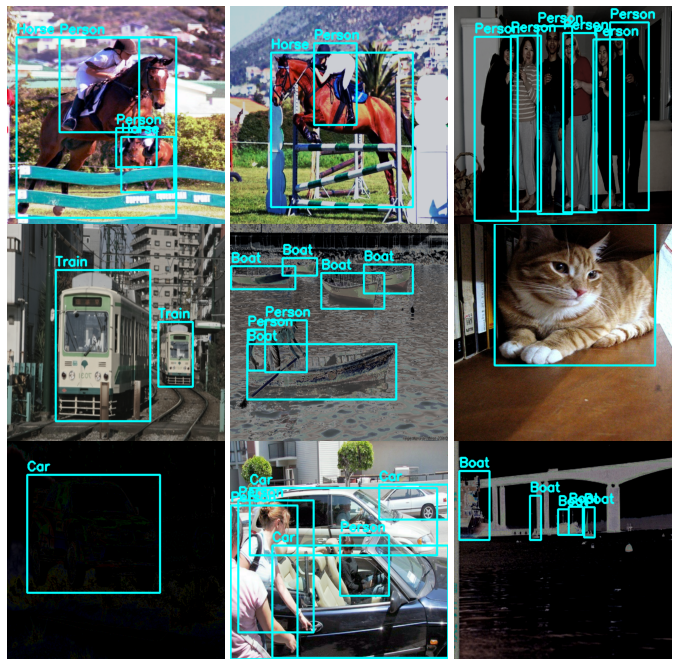

In [6]:
# train_ds is batched as a (images, bounding_boxes) tuple bounding_boxes are ragged

train_ds, train_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="train", batch_size=BATCH_SIZE
)
val_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="validation", batch_size=BATCH_SIZE
)

random_flip = keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh")
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    geometric=False,
)


def augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    inputs = random_flip(inputs)
    return inputs


train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(train_ds, bounding_box_format="xywh")

In [7]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
model = keras_cv.models.RetinaNet(
    # number of classes to be used in box classification
    classes=20,
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    # KerasCV offers a set of pre-configured backbones
    backbone="resnet50",
    # Each backbone comes with multiple pre-trained weights
    # These weights match the weights available in the `keras_cv.model` class.
    backbone_weights="imagenet",
    # include_rescaling tells the model whether your input images are in the default
    # pixel range (0, 255) or if you have already rescaled your inputs to the range
    # (0, 1).  In our case, we feed our model images with inputs in the range (0, 255).
    include_rescaling=True,
    # Typically, you'll want to set this to False when training a real model.
    # evaluate_train_time_metrics=True makes `train_step()` incompatible with TPU,
    # and also causes a massive performance hit.  It can, however be useful to produce
    # train time metrics when debugging your model training pipeline.
    evaluate_train_time_metrics=False,
)
# Fine-tuning a RetinaNet is as simple as setting backbone.trainable = False
model.backbone.trainable = False

94765736/94765736 [==============================] - 7s 0us/step


In [9]:
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(20),
        bounding_box_format="xywh",
        name="Mean Average Precision",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]


In [10]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=[
        keras_cv.metrics.COCOMeanAveragePrecision(
            class_ids=range(20),
            bounding_box_format="xywh",
            name="Mean Average Precision",
        ),
        keras_cv.metrics.COCORecall(
            class_ids=range(20),
            bounding_box_format="xywh",
            max_detections=100,
            name="Recall",
        ),
    ],
)

In [11]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="logs"),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    # Uncomment to train your own RetinaNet
    keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True),
]

In [12]:
model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=5,
    callbacks=callbacks,
)
model.save_weights(CHECKPOINT_PATH)

Epoch 1/5
157/157 [==============================] - 311s 2s/step - loss: 26.3370 - classification_loss: 13.5390 - regularization_loss: 0.0000e+00 - box_loss: 12.7980 - val_Mean Average Precision: 0.0039 - val_Recall: 0.0186 - val_loss: 22.5304 - val_classification_loss: 10.8997 - val_box_loss: 11.6307 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/5
157/157 [==============================] - 270s 2s/step - loss: 21.4703 - classification_loss: 10.6073 - regularization_loss: 0.0000e+00 - box_loss: 10.8630 - val_Mean Average Precision: 0.0104 - val_Recall: 0.0259 - val_loss: 19.9597 - val_classification_loss: 9.5221 - val_box_loss: 10.4375 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/5
157/157 [==============================] - 262s 2s/step - loss: 19.3196 - classification_loss: 9.4921 - regularization_loss: 0.0000e+00 - box_loss: 9.8275 - val_Mean Average Precision: 0.0217 - val_Recall: 0.0477 - val_loss: 18.6754 - val_classification_loss: 9.2458 - val_box_loss

In [13]:
model.load_weights(INFERENCE_CHECKPOINT_PATH)
metrics = model.evaluate(val_ds.take(100), return_dict=True)
print(metrics)

100/100 [==============================] - 615s 6s/step - Mean Average Precision: 0.0266 - Recall: 0.0988 - loss: 16.8958 - classification_loss: 7.9462 - box_loss: 8.9496 - regularization_loss: 0.0000e+00
{'Mean Average Precision': 0.026638153940439224, 'Recall': 0.09880609810352325, 'loss': 16.895788192749023, 'classification_loss': 7.946197509765625, 'box_loss': 8.94958782196045, 'regularization_loss': 0.0}
